In [26]:
from keras.applications import VGG16
from keras import layers
from keras import models
from imutils import paths
from keras.preprocessing.image import img_to_array
import imutils
import numpy as np
import cv2
import progressbar
from sklearn.utils import shuffle
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt


# Dataset

## Preprocessing

In [2]:
class Preprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA, dataFormat=None):
        self.width = width
        self.height = height
        self.inter = inter
        self.dataFormat = dataFormat
        self.load_widgets = ['Loading Data: ', progressbar.Percentage(), ' ', progressbar.Bar(), ' ', progressbar.ETA()]
        
    def getImagesPath(self, img_dir):
        return list(paths.list_images(img_dir))
    
    def load_data(self, img_paths):
        data = []
        labels = []
        
        prog = progressbar.ProgressBar(maxval=len(img_paths), widgets=self.load_widgets).start()
        for (i, path) in enumerate(img_paths):
            img = cv2.imread(path)
            img = self.resize(img)
            img =self.img2array(img)
            data.append(img)
            
            label = path.split('/')[-1].split()[0]
            labels.append(label)
            
            prog.update(i)
        
        data= np.array(data).astype('float') / 255.0
        labels = np.array(labels)
        
        prog.finish()
        return (data, labels)
    
    def resize(self, img):
        (h, w) = img.shape[:2]
        dh = 0
        dw = 0
        
        # resizing
        if w < h:
            img = imutils.resize(img, width=self.width, inter=self.inter)
            dh = int((img.shape[0] - self.height) / 2.0)
        else:
            img = imutils.resize(img, height=self.height, inter=self.inter)
            dw = int((img.shape[1] - self.width) / 2.0)
        
        #cropping
        (h, w)= img.shape[:2]
        img = img[dh:h - dh, dw:w - dw]
        
        # maintain spatial dimension
        return cv2.resize(img, (self.width, self.height), interpolation=self.inter)
    
    def img2array(self, img):
        return img_to_array(img, data_format=self.dataFormat)
            

## Initialization

In [3]:
preprop = Preprocessor(200, 88)

## Get path

In [4]:
img_dir = 'C:/Users/Tajr/Desktop/Data/RadonPlus/RadonTechnology/Dev/Deep Learning/Datasets/computervision/zindi/working/high/'
img_paths = shuffle(preprop.getImagesPath(img_dir))
label = img_paths[0].split('/')[-1].split()[0]
label

'MidVegetativePhase'

## Load Data

In [5]:
(data, labels) = preprop.load_data(img_paths)

Loading Data: 100% |############################################| Time: 0:00:23


In [6]:
data.shape

(5103, 88, 200, 3)

## Binarization

In [7]:
lb = LabelBinarizer()
targets = lb.fit_transform(labels)

classNames = lb.classes_


## Splitting

In [8]:
(trainX, test_samples, trainY, test_targets) = train_test_split(data, targets, random_state=42, test_size=0.5)
(testX, validationX, testY, validationY) = train_test_split(test_samples, test_targets, random_state=42, test_size=0.5)

## Network

In [9]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(88, 200, 3))

In [10]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 88, 200, 3)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 88, 200, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 88, 200, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 44, 100, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 44, 100, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 44, 100, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 22, 50, 128)       0     

In [11]:
for (i, layer) in enumerate(conv_base.layers):
    print('[INFO] {}\t{}'.format(i, layer.__class__.__name__))

[INFO] 0	InputLayer
[INFO] 1	Conv2D
[INFO] 2	Conv2D
[INFO] 3	MaxPooling2D
[INFO] 4	Conv2D
[INFO] 5	Conv2D
[INFO] 6	MaxPooling2D
[INFO] 7	Conv2D
[INFO] 8	Conv2D
[INFO] 9	Conv2D
[INFO] 10	MaxPooling2D
[INFO] 11	Conv2D
[INFO] 12	Conv2D
[INFO] 13	Conv2D
[INFO] 14	MaxPooling2D
[INFO] 15	Conv2D
[INFO] 16	Conv2D
[INFO] 17	Conv2D
[INFO] 18	MaxPooling2D


## Head Installation

In [12]:
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               3146240   
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3591      
Total params: 17,864,519
Trainable params: 17,864,519
Non-trainable params: 0
_________________________________________________________________


## Freezing Body layers

In [13]:
for layer in conv_base.layers:
    layer.trainable = False


In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               3146240   
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3591      
Total params: 17,864,519
Trainable params: 3,149,831
Non-trainable params: 14,714,688
_________________________________________________________________


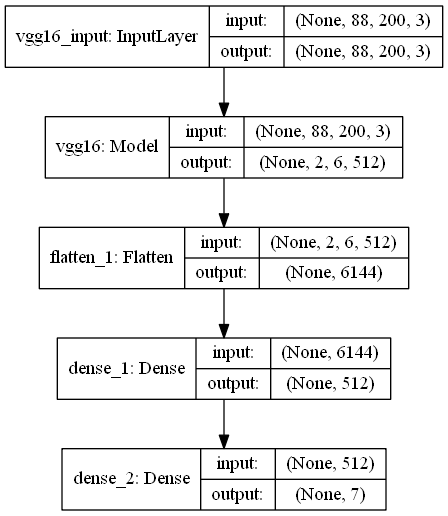

In [15]:
plot_model(model, to_file='serialized/architecture/architecture.png', show_shapes=True)

## Augmentation

In [16]:
aug = ImageDataGenerator(rotation_range=30, shear_range=0.2, zoom_range=0.2, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True, fill_mode='nearest')

## Model Warming Up

In [17]:
model.compile(optimizer=RMSprop(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])

In [18]:
model.fit_generator(aug.flow(trainX, trainY, batch_size=32), validation_data=(validationX, validationY), epochs=25, steps_per_epoch=len(trainX)//32)

Epoch 1/25
79/79 [==============================] - 76s 956ms/step - loss: 2.3291 - acc: 0.2815 - val_loss: 1.7492 - val_acc: 0.3049
Epoch 2/25
79/79 [==============================] - 55s 696ms/step - loss: 1.6884 - acc: 0.3239 - val_loss: 1.7634 - val_acc: 0.2947
Epoch 3/25
79/79 [==============================] - 56s 712ms/step - loss: 1.5782 - acc: 0.3609 - val_loss: 1.7480 - val_acc: 0.2908
Epoch 4/25
79/79 [==============================] - 53s 674ms/step - loss: 1.5618 - acc: 0.3696 - val_loss: 1.5458 - val_acc: 0.3958
Epoch 5/25
79/79 [==============================] - 55s 702ms/step - loss: 1.5419 - acc: 0.3795 - val_loss: 1.5725 - val_acc: 0.3660
Epoch 6/25
79/79 [==============================] - 56s 703ms/step - loss: 1.5211 - acc: 0.3759 - val_loss: 1.5427 - val_acc: 0.3762
Epoch 7/25
79/79 [==============================] - 52s 661ms/step - loss: 1.5042 - acc: 0.3970 - val_loss: 1.5387 - val_acc: 0.3793
Epoch 8/25
79/79 [==============================] - 59s 742ms/step - 

In [19]:
result = model.evaluate(testX, testY)

1276/1276 [==============================] - 21s 17ms/step


In [20]:
result

[1.5205635232237813, 0.41144201159477234]

## Unfreeze conv_base layers from top to bottom

In [21]:
for layer in conv_base.layers[15:]:
    layer.trainable = True

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 6, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               3146240   
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3591      
Total params: 10,785,095
Trainable params: 3,149,831
Non-trainable params: 7,635,264
_________________________________________________________________


C:\Users\Tajr\Anaconda3\envs\Deep_Learning\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


## Recompile and Train the model

In [23]:
model.compile(optimizer=SGD(lr=0.001), loss='categorical_crossentropy', metrics=['acc'])

In [25]:
history = model.fit_generator(aug.flow(trainX, trainY, batch_size=32), epochs=100, steps_per_epoch=len(trainX)//32, validation_data=(validationX, validationY))

Epoch 1/100
79/79 [==============================] - 62s 788ms/step - loss: 1.3948 - acc: 0.4450 - val_loss: 1.4973 - val_acc: 0.3989
Epoch 2/100
79/79 [==============================] - 60s 756ms/step - loss: 1.3679 - acc: 0.4502 - val_loss: 1.5061 - val_acc: 0.3997
Epoch 3/100
79/79 [==============================] - 61s 774ms/step - loss: 1.3649 - acc: 0.4478 - val_loss: 1.4833 - val_acc: 0.4138
Epoch 4/100
79/79 [==============================] - 60s 761ms/step - loss: 1.3607 - acc: 0.4510 - val_loss: 1.5181 - val_acc: 0.3973
Epoch 5/100
79/79 [==============================] - 60s 757ms/step - loss: 1.3433 - acc: 0.4585 - val_loss: 1.4981 - val_acc: 0.4099
Epoch 6/100
79/79 [==============================] - 61s 772ms/step - loss: 1.3517 - acc: 0.4538 - val_loss: 1.5095 - val_acc: 0.3942
Epoch 7/100
79/79 [==============================] - 70s 882ms/step - loss: 1.3462 - acc: 0.4625 - val_loss: 1.4810 - val_acc: 0.4138
Epoch 8/100
79/79 [==============================] - 63s 792ms

Epoch 62/100
79/79 [==============================] - 55s 691ms/step - loss: 1.2174 - acc: 0.5224 - val_loss: 1.5056 - val_acc: 0.4201
Epoch 63/100
79/79 [==============================] - 54s 688ms/step - loss: 1.2412 - acc: 0.4938 - val_loss: 1.5274 - val_acc: 0.4083
Epoch 64/100
79/79 [==============================] - 55s 691ms/step - loss: 1.2193 - acc: 0.5165 - val_loss: 1.5040 - val_acc: 0.4326
Epoch 65/100
79/79 [==============================] - 55s 693ms/step - loss: 1.2102 - acc: 0.5149 - val_loss: 1.5955 - val_acc: 0.3989
Epoch 66/100
79/79 [==============================] - 55s 692ms/step - loss: 1.2172 - acc: 0.5129 - val_loss: 1.5168 - val_acc: 0.4232
Epoch 67/100
79/79 [==============================] - 54s 689ms/step - loss: 1.2048 - acc: 0.5139 - val_loss: 1.5386 - val_acc: 0.4177
Epoch 68/100
79/79 [==============================] - 55s 691ms/step - loss: 1.2002 - acc: 0.5170 - val_loss: 1.5523 - val_acc: 0.4216
Epoch 69/100
79/79 [==============================] - 5

# Plotting

In [28]:
history_dict = history.history
epoch = np.arange(1, len(history_dict['acc']) + 1)
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

## Accuracy

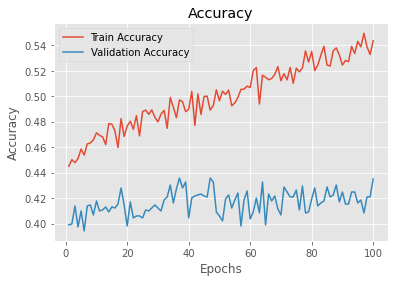

In [29]:
plt.style.use('ggplot')
plt.plot(epoch, acc, label='Train Accuracy')
plt.plot(epoch, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Loss

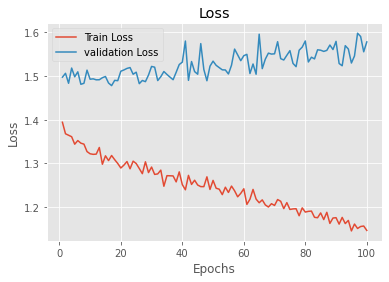

In [30]:
plt.clf()
plt.plot(epoch, loss, label='Train Loss')
plt.plot(epoch, val_loss, label='validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## eVALUATION

In [31]:
result = model.evaluate(testX, testY)

1276/1276 [==============================] - 20s 16ms/step


In [32]:
result

[1.6103312599247899, 0.4098746180534363]